# OPTICS Prediction: Factor Attribution & Formation Forecasting

This notebook builds on the clustering analysis from `optics-clustering.ipynb`.
It answers two questions:
1. **Factor Attribution**: What feature values preceded cluster formation events?
2. **Prediction**: Can we forecast when a formation will occur using features at T-1?

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print('Imports loaded. Run optics-clustering.ipynb first to generate:\n'
      '  - ts_df (feature DataFrame)\n'
      '  - df_formations (formation events)\n'
      '  - pair_classification (pair categories)\n'
      '  - cluster_history (clustering results)')

Imports loaded. Run optics-clustering.ipynb first to generate:
  - ts_df (feature DataFrame)
  - df_formations (formation events)
  - pair_classification (pair categories)
  - cluster_history (clustering results)


## 1. Load Data from Clustering Notebook

This cell expects `ts_df`, `df_formations`, `pair_classification`, and `cluster_history` to be in memory.
Run `optics-clustering.ipynb` first, or load saved artifacts.

In [2]:
# Load data from pickle files saved by optics-clustering.ipynb
import os
import pickle

data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data')
required_files = ['ts_df', 'df_formations', 'pair_classification', 'cluster_history']

missing = [name for name in required_files if not os.path.exists(os.path.join(data_dir, f'{name}.pkl'))]

if missing:
    raise RuntimeError(
        f'Missing data files: {missing}\n'
        f'Run optics-clustering.ipynb first to generate pickle files in {data_dir}/'
    )

for name in required_files:
    path = os.path.join(data_dir, f'{name}.pkl')
    with open(path, 'rb') as f:
        globals()[name] = pickle.load(f)
    print(f'Loaded {name} from {path}')

print(f'\nts_df: {len(ts_df)} rows')
print(f'df_formations: {len(df_formations)} formation events')
print(f'pair_classification: {len(pair_classification)} pairs')
print(f'cluster_history: {len(cluster_history)} rows')

# Get feature columns (exclude Price, Returns, Ticker)
feature_cols = [c for c in ts_df.columns if c not in ['Price', 'Returns', 'Ticker']]
print(f'Feature columns: {feature_cols}')

Loaded ts_df from /Users/jack/Documents/code/pairs-test/research/data/ts_df.pkl
Loaded df_formations from /Users/jack/Documents/code/pairs-test/research/data/df_formations.pkl
Loaded pair_classification from /Users/jack/Documents/code/pairs-test/research/data/pair_classification.pkl
Loaded cluster_history from /Users/jack/Documents/code/pairs-test/research/data/cluster_history.pkl

ts_df: 62821 rows
df_formations: 19883 formation events
pair_classification: 776 pairs
cluster_history: 54426 rows
Feature columns: ['Vol_Short', 'Beta_SPX_Short', 'Beta_Sector_Short', 'Vol_Medium', 'Beta_SPX_Medium', 'Beta_Sector_Medium', 'RSI', 'Momentum_5H', 'Momentum_10H', 'Momentum_Accel', 'Vol_Regime_Shift', 'Beta_SPX_Regime_Shift', 'Beta_Sector_Regime_Shift']


## 2. Factor Attribution

For each formation event, capture feature values at the formation timestamp and compare
to the baseline distribution (non-formation timestamps). This reveals which features
have unusual values when relationships form.

In [3]:
# ============================================================================
# FACTOR ATTRIBUTION: What features are unusual at formation events?
# ============================================================================

feature_cols = [c for c in ts_df.columns if c not in ['Price', 'Returns', 'Ticker']]

# Collect feature snapshots at formation events
formation_features = []

for _, event in df_formations.iterrows():
    ts = event['Formation_Time']
    t1, t2 = event['Ticker_1'], event['Ticker_2']
    
    try:
        feat_1 = ts_df.xs(t1, level='Ticker').loc[ts, feature_cols]
        feat_2 = ts_df.xs(t2, level='Ticker').loc[ts, feature_cols]
        
        # Average features of the two assets at formation time
        avg_feat = (feat_1 + feat_2) / 2
        avg_feat['Pair'] = event['Pair']
        avg_feat['Formation_Time'] = ts
        avg_feat['is_formation'] = True
        formation_features.append(avg_feat)
    except (KeyError, TypeError):
        continue

df_formation_features = pd.DataFrame(formation_features)
print(f'Collected features for {len(df_formation_features)} formation events')

# Baseline: sample random ticker PAIRS at non-formation timestamps
# This matches the per-pair structure of formation features (avg of 2 tickers)
# instead of averaging ALL tickers at each timestamp.
all_timestamps = ts_df.index.get_level_values('Datetime').unique()
all_tickers = ts_df.index.get_level_values('Ticker').unique().tolist()
formation_timestamps = set(df_formations['Formation_Time'].values)
non_formation_ts = [ts for ts in all_timestamps if ts not in formation_timestamps]

np.random.seed(42)
sample_size = min(len(non_formation_ts), len(formation_features) * 3)
sampled_non_formation = np.random.choice(non_formation_ts, size=sample_size, replace=False)

baseline_features = []
for ts in sampled_non_formation:
    try:
        snapshot = ts_df.xs(ts, level='Datetime')[feature_cols]
    except KeyError:
        continue
    if len(snapshot) < 2:
        continue
    available = snapshot.index.tolist()
    t1, t2 = np.random.choice(available, size=2, replace=False)
    avg = (snapshot.loc[t1] + snapshot.loc[t2]) / 2
    avg['is_formation'] = False
    baseline_features.append(avg)

df_baseline_features = pd.DataFrame(baseline_features)
print(f'Collected features for {len(df_baseline_features)} non-formation timestamps')

# ============================================================================
# Compare formation vs non-formation feature distributions
# ============================================================================

print(f"\n{'='*80}")
print('FACTOR ATTRIBUTION: Formation vs Non-Formation Feature Comparison')
print(f"{'='*80}")

comparison_results = []
for col in feature_cols:
    form_vals = df_formation_features[col].astype(float).dropna()
    base_vals = df_baseline_features[col].astype(float).dropna()
    
    if len(form_vals) > 5 and len(base_vals) > 5:
        form_mean = form_vals.mean()
        base_mean = base_vals.mean()
        base_std = base_vals.std()
        
        # Z-score of formation mean relative to baseline
        z_score = (form_mean - base_mean) / base_std if base_std > 0 else 0
        
        comparison_results.append({
            'Feature': col,
            'Formation_Mean': form_mean,
            'Baseline_Mean': base_mean,
            'Baseline_Std': base_std,
            'Z_Score': z_score,
            'Abs_Z': abs(z_score)
        })

df_comparison = pd.DataFrame(comparison_results).sort_values('Abs_Z', ascending=False)

print('\nFeatures ranked by deviation at formation events (|Z-score|):')
print(df_comparison[['Feature', 'Formation_Mean', 'Baseline_Mean', 'Z_Score']].to_string(index=False))

# Highlight significant features
significant = df_comparison[df_comparison['Abs_Z'] > 1.0]
if len(significant) > 0:
    print(f'\nSignificant features (|Z| > 1.0): {list(significant["Feature"].values)}')
else:
    print('\nNo features with |Z| > 1.0 at formation events')

Collected features for 19883 formation events
Collected features for 1578 non-formation timestamps

FACTOR ATTRIBUTION: Formation vs Non-Formation Feature Comparison

Features ranked by deviation at formation events (|Z-score|):
                 Feature  Formation_Mean  Baseline_Mean   Z_Score
               Vol_Short        0.010555       0.011910 -0.262277
              Vol_Medium        0.011353       0.012376 -0.247639
      Beta_Sector_Medium        0.923632       0.965402 -0.177246
         Beta_SPX_Medium        1.917167       2.003565 -0.146069
       Beta_Sector_Short        0.918720       0.965690 -0.136489
        Vol_Regime_Shift       -0.058834      -0.033475 -0.117615
          Beta_SPX_Short        1.982701       2.045839 -0.060583
                     RSI       52.928906      52.468956  0.057280
             Momentum_5H        0.001893       0.002620 -0.027949
   Beta_SPX_Regime_Shift        0.065534       0.042274  0.027597
            Momentum_10H        0.004394     

## 3. Factor Attribution Visualization

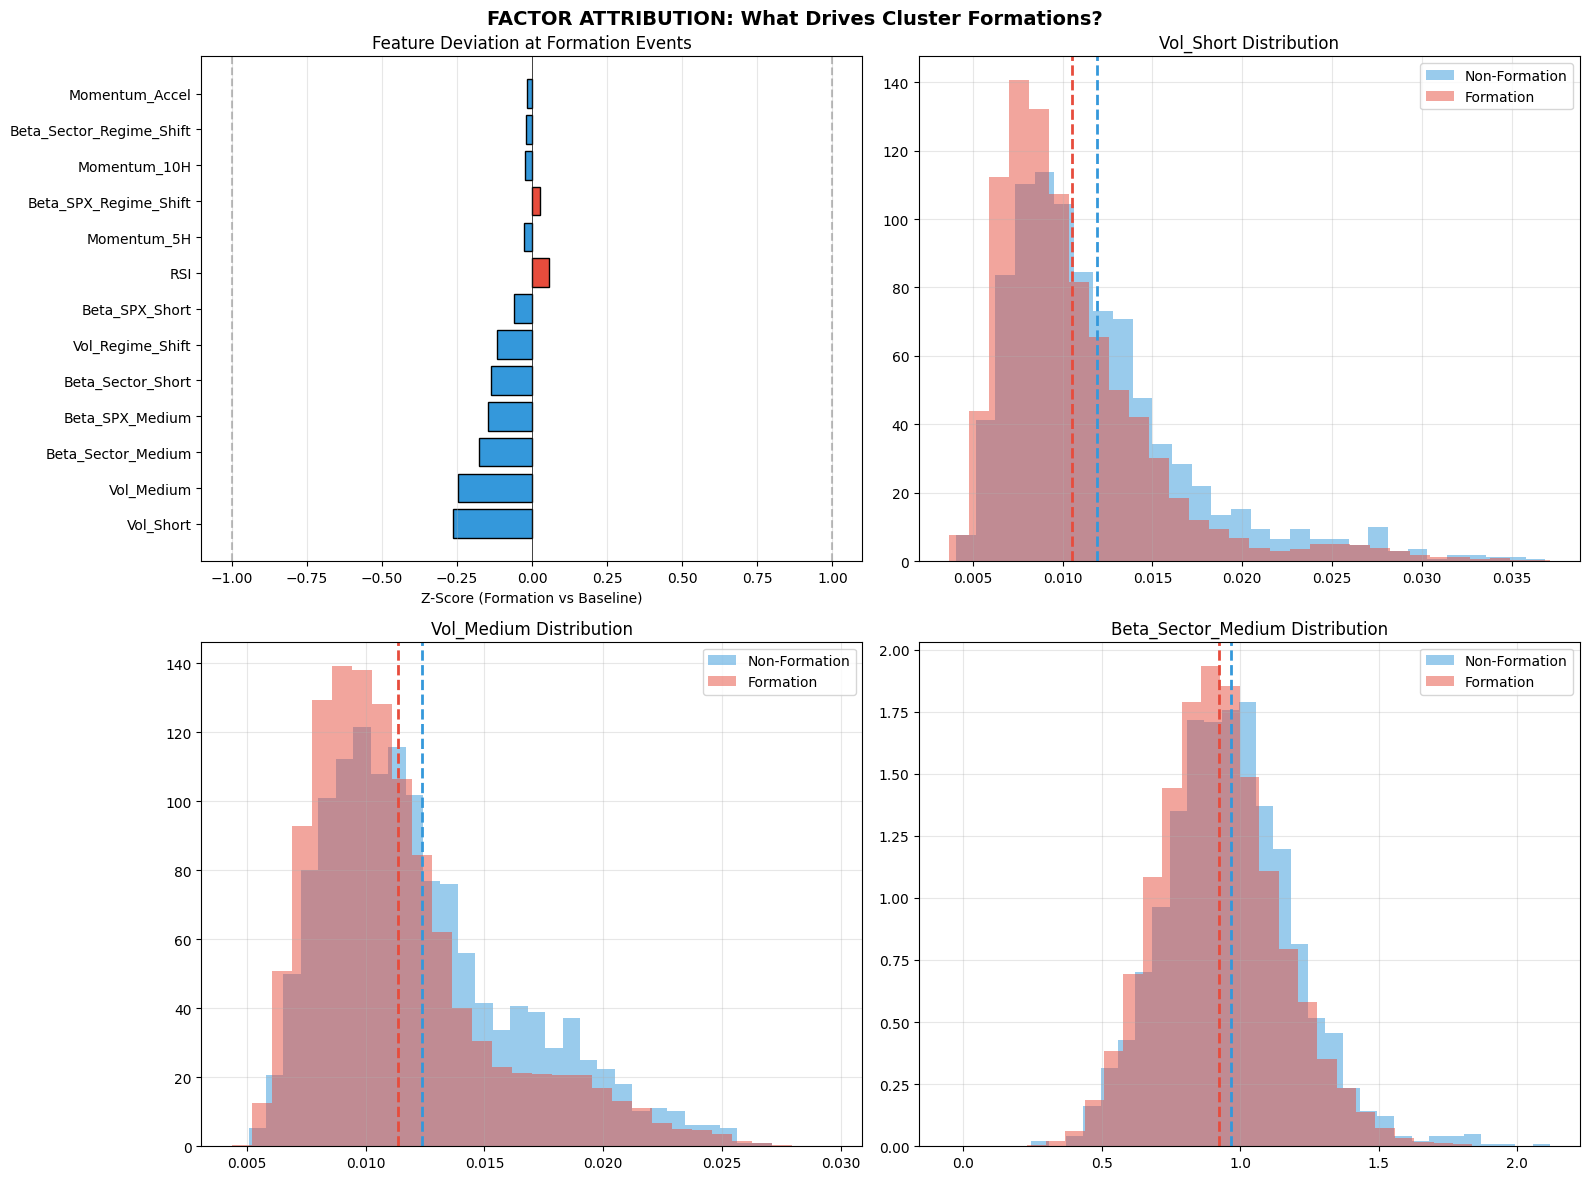

In [4]:
# ============================================================================
# VISUALIZE FACTOR ATTRIBUTION
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Z-scores bar chart
ax = axes[0, 0]
colors = ['#e74c3c' if z > 0 else '#3498db' for z in df_comparison['Z_Score']]
ax.barh(df_comparison['Feature'], df_comparison['Z_Score'], color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=0.5)
ax.axvline(x=1, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=-1, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Z-Score (Formation vs Baseline)')
ax.set_title('Feature Deviation at Formation Events')
ax.grid(axis='x', alpha=0.3)

# Plot 2-4: Top 3 most significant features - distribution comparison
top_features = df_comparison.head(3)['Feature'].values

for i, feat in enumerate(top_features):
    row, col = divmod(i + 1, 2)
    ax = axes[row, col]
    
    form_vals = df_formation_features[feat].astype(float).dropna()
    base_vals = df_baseline_features[feat].astype(float).dropna()
    
    ax.hist(base_vals, bins=30, alpha=0.5, label='Non-Formation', color='#3498db', density=True)
    ax.hist(form_vals, bins=30, alpha=0.5, label='Formation', color='#e74c3c', density=True)
    ax.axvline(base_vals.mean(), color='#3498db', linestyle='--', linewidth=2)
    ax.axvline(form_vals.mean(), color='#e74c3c', linestyle='--', linewidth=2)
    ax.set_title(f'{feat} Distribution')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('FACTOR ATTRIBUTION: What Drives Cluster Formations?', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Predictive Framework

Build a model that predicts formation events using features at T-1.
- **Features**: All clustering features at the timestamp BEFORE the formation
- **Label**: Did a formation event happen at the next timestamp?
- **Evaluation**: TimeSeriesSplit cross-validation to avoid look-ahead bias

In [5]:
# ============================================================================
# BUILD PREDICTIVE DATASET
# ============================================================================
# For each pair, at each timestamp, create:
#   Features: average feature values of the two stocks at time T-1
#   Label: did they form a cluster at time T?

print('Building predictive dataset...')

feature_cols = [c for c in ts_df.columns if c not in ['Price', 'Returns', 'Ticker']]
all_timestamps = sorted(ts_df.index.get_level_values('Datetime').unique())

# Focus on transient pairs
target_pairs = pair_classification[pair_classification['Category'] == 'transient']
if len(target_pairs) == 0:
    target_pairs = pair_classification.head(20)
    print('No transient pairs found, using top 20 pairs')

# Build formation lookup: set of (pair, timestamp) for fast checking
formation_lookup = set()
for _, ev in df_formations.iterrows():
    formation_lookup.add((ev['Pair'], ev['Formation_Time']))

print(f'Building dataset for {len(target_pairs)} pairs across {len(all_timestamps)} timestamps...')

dataset_rows = []
for _, pair_row in target_pairs.iterrows():
    pair_name = pair_row['Pair']
    t1, t2 = pair_name.split('-')
    
    for i in range(1, len(all_timestamps)):
        ts_prev = all_timestamps[i - 1]  # T-1: features from here
        ts_curr = all_timestamps[i]       # T: label from here
        
        try:
            feat_1 = ts_df.xs(t1, level='Ticker').loc[ts_prev, feature_cols]
            feat_2 = ts_df.xs(t2, level='Ticker').loc[ts_prev, feature_cols]
        except (KeyError, TypeError):
            continue
        
        # Average features + absolute difference features
        avg_feat = (feat_1 + feat_2) / 2
        diff_feat = (feat_1 - feat_2).abs()
        diff_feat.index = [f'{c}_diff' for c in diff_feat.index]
        
        row = pd.concat([avg_feat, diff_feat])
        row['pair'] = pair_name
        row['timestamp'] = ts_curr
        row['formation'] = 1 if (pair_name, ts_curr) in formation_lookup else 0
        dataset_rows.append(row)

df_pred = pd.DataFrame(dataset_rows)

# Drop rows with NaN features
pred_feature_cols = [c for c in df_pred.columns if c not in ['pair', 'timestamp', 'formation']]
df_pred = df_pred.dropna(subset=pred_feature_cols)

n_positive = df_pred['formation'].sum()
n_total = len(df_pred)
print(f'\nDataset built:')
print(f'  Total samples: {n_total}')
print(f'  Formation events (positive): {n_positive} ({n_positive/n_total:.2%})')
print(f'  Non-formation (negative): {n_total - n_positive}')
print(f'  Feature columns: {len(pred_feature_cols)}')

Building predictive dataset...
Building dataset for 764 pairs across 1578 timestamps...

Dataset built:
  Total samples: 1198055
  Formation events (positive): 19784 (1.65%)
  Non-formation (negative): 1178271
  Feature columns: 26


In [ ]:
# ============================================================================
# TRAIN PREDICTIVE MODEL WITH TIME-SERIES CROSS-VALIDATION
# ============================================================================

X = df_pred[pred_feature_cols].astype(float).values
y = df_pred['formation'].astype(int).values

# Sort by timestamp to respect temporal ordering
sort_idx = df_pred['timestamp'].argsort()
X = X[sort_idx]
y = y[sort_idx]

# TimeSeriesSplit: ensures training always precedes test
tscv = TimeSeriesSplit(n_splits=5)

print(f"{'='*80}")
print('PREDICTIVE MODEL: Time-Series Cross-Validation')
print(f"{'='*80}")

# Compute class weight for imbalanced data
n_neg = (y == 0).sum()
n_pos = (y == 1).sum()
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
sample_weights_map = {0: 1.0, 1: scale_pos_weight}
print(f'Class imbalance ratio: {scale_pos_weight:.1f}:1 (negative:positive)')

fold_results = []
feature_importances_all = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Gradient Boosting (handles imbalanced data better)
    model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
    train_weights = np.array([sample_weights_map[yi] for yi in y_train])
    model.fit(X_train_scaled, y_train, sample_weight=train_weights)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else y_pred
    
    # Metrics
    test_pos = y_test.sum()
    if test_pos > 0 and test_pos < len(y_test):
        auc = roc_auc_score(y_test, y_prob)
    else:
        auc = np.nan
    
    if test_pos > 0:
        from sklearn.metrics import precision_score, recall_score
        y_pred_binary = (y_prob >= 0.5).astype(int)
        prec = precision_score(y_test, y_pred_binary, zero_division=0)
        rec = recall_score(y_test, y_pred_binary, zero_division=0)
    else:
        prec, rec = np.nan, np.nan
    
    fold_results.append({
        'fold': fold + 1,
        'train_size': len(y_train),
        'test_size': len(y_test),
        'test_positives': int(test_pos),
        'auc': auc,
        'precision': prec,
        'recall': rec
    })
    
    feature_importances_all.append(model.feature_importances_)
    
    print(f'Fold {fold+1}: AUC={auc:.3f}, Train={len(y_train)}, Test={len(y_test)}, Positives={test_pos}')

df_fold_results = pd.DataFrame(fold_results)
valid_folds = df_fold_results.dropna(subset=['auc'])
print(f'\nMean AUC: {valid_folds["auc"].mean():.3f} (+/- {valid_folds["auc"].std():.3f})')

# ============================================================================
# FEATURE IMPORTANCE
# ============================================================================

avg_importance = np.mean(feature_importances_all, axis=0)
importance_df = pd.DataFrame({
    'Feature': pred_feature_cols,
    'Importance': avg_importance
}).sort_values('Importance', ascending=False)

print(f'\nTop 15 Most Important Features for Predicting Formations:')
print(importance_df.head(15).to_string(index=False))

PREDICTIVE MODEL: Time-Series Cross-Validation
Class imbalance ratio: 59.6:1 (negative:positive)
Fold 1: AUC=0.764, Train=199680, Test=199675, Positives=3140
Fold 2: AUC=0.746, Train=399355, Test=199675, Positives=3192
Fold 3: AUC=0.742, Train=599030, Test=199675, Positives=3326
Fold 4: AUC=0.757, Train=798705, Test=199675, Positives=3447


In [ ]:
# ============================================================================
# VISUALIZE PREDICTION RESULTS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature importance
top_n = min(15, len(importance_df))
top_imp = importance_df.head(top_n)
axes[0].barh(range(top_n), top_imp['Importance'].values, color='#3498db', edgecolor='black')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(top_imp['Feature'].values)
axes[0].set_xlabel('Importance')
axes[0].set_title('Top Features for Formation Prediction')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: AUC across folds
valid_folds = df_fold_results.dropna(subset=['auc'])
axes[1].bar(valid_folds['fold'], valid_folds['auc'], color='#2ecc71', edgecolor='black')
axes[1].axhline(y=0.5, color='red', linestyle='--', label='Random baseline (0.5)')
axes[1].axhline(y=valid_folds['auc'].mean(), color='blue', linestyle='--', 
                label=f'Mean AUC ({valid_folds["auc"].mean():.3f})')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('AUC')
axes[1].set_title('Model Performance Across Time Folds')
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('FORMATION PREDICTION MODEL RESULTS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print('PREDICTION ANALYSIS COMPLETE')
print(f"{'='*80}")
print(f'Mean AUC: {valid_folds["auc"].mean():.3f}')
if valid_folds['auc'].mean() > 0.55:
    print('Model shows predictive signal above random chance.')
    print(f'Top predictive features: {list(importance_df.head(5)["Feature"].values)}')
else:
    print('Model performance near random chance.')
    print('Consider: additional features, different pair selection, or longer training period.')